
# <p style="text-align: center;">EE 380L: Data Mining</p>
# <p style="text-align: center;">Assignment 3</p>
## <p style="text-align: center;">Total points: 80</p>
## <p style="text-align: center;">Due: Tuesday, March 20th, submitted via Canvas by 11:59 pm</p>

Your homework should be written in a **Jupyter notebook**. You may work in groups of two if you wish. Only one student per team needs to submit the assignment on Canvas.  But be sure to include name and UTID for both students.  Homework groups will be created and managed through Canvas, so please do not arbitrarily change your homework group.  

Also, please make sure your code runs and the graphics (and anything else) are displayed in your notebook before submitting. (%matplotlib inline)

# Question 1 - Gradient Descent (5+12+3 = 20pts)

In this question you will implement vanilla SGD and 2 adaptive gradient update techniques called Adagrad and Adadelta. In addition, you will also implement ridge regularization. 

1. Using stochastic gradient descent, derive the coefficent updates for all 4 coefficients of the model: $$ y = w_0 + w_1*x_1 + w_2*x_1*x_1 + w_3*x_2*x_2 + w_4*x_2 $$ Hint: start from the cost function (Assume sum of squared error). If you write the math by hand, submit that as a separate file and make a reference to it in your notebook or include the image in your notebook.
2. Write Python code for an SGD solution to the non-linear model $$ y = w_0 + w_1*x_1 + w_2*x_1*x_1 + w_3*x_2*x_2 + w_4*x_2 $$ Try to format similarly to scikit-learn's models. Your Python class should take as input the learning_rate, regularization_constant and number of epochs. The fit method must take as input X,y and a choice of update_rule as 'SGD', 'adagrad' or 'adadelta' (Notes on implementation below). The _predict_ method takes an X value (optionally, an array of values). Use your new gradient descent regression to predict the data given in 'samples.csv', for 20 epochs (this may have to increase for adadelta), using learning rates: [.0001, .001, .01, 0.1, 1, 10, 100] and regularization constants in the range: [0,10,100] . Plot MSE and the $w$ parameters as a function of epoch count (20 epochs) for the best combination of learning_rate and regularization for both SGD, Adagrad and Adadelta. ie you should have a plot of MSE and parameter updates for SGD, adagrad and adadelta. Report the MSE at the end of 10 epochs for all 3.
3. Based on the experiments, answer the following:

1. Among SGD and Adagrad, which one allows for larger initial setting of the learning_rate? Why?
2. Mention one benefit and one drawback of Adadelta over Adagrad

# Notes on Adagrad/Adadelta
Adagrad (http://ruder.io/optimizing-gradient-descent/) differs from vanilla SGD in that the learning rate of each weight changes over updates. A cache is maintained that holds the sum of squares of all gradients upto the current update. The learning_rate is divided by the cache, resulting in a different learning rate for each weight. A consequence of this update rule is that weights that have already seen large gradients (made large jumps) make smaller updates in subsequent iterations.
Specifically, the steps can be listed as below:
1. cache = cache + (gradients^2)
2. weights = weights + ((learning_rate)/sqrt(cache+1e-6))*gradients

The key difference between Adadelta and Adagrad is that the former uses a weighted sum for each update of the cache. Also, you will not need to use a learning rate to make Adadelta work. In addition to the link above, the paper on Adadelta is a great resource to implement it correctly (https://arxiv.org/pdf/1212.5701.pdf)

# (Optional) Notes on Training with Gradient Descent
1. Compute error: This consists of a prediction error and a regularization term. From an implementation perspective, this is a function that takes as input the truth, prediction and regularization hyperparameter and returns an error
2. Compute gradients: Take a derivative of the error in terms of the weights. This can be modelled as a function that takes as input the error and features and returns the gradients for each weight
3. Update weights: Weight updates can be done using vanilla SGD or adaptive techniques. The update function takes as inputs the gradient and hyperparameters and returns the new weights.

### 1
<img src="1_math.png">

### 2

In [146]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,KFold)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import math
import matplotlib.pyplot as plt
import copy

class SGD:
    def __init__(self, learning_rate, regularization_constant, epochs):
        self.learning_rate = learning_rate
        self.regularization_constant = regularization_constant
        self.epochs = epochs
        self.plot_weights = []
        self.plot_errors = []
        self.plot_epoch = []
        self.epoch_num = 0
        self.weights = np.random.random_sample(5,)
        self.X = []
        self.y = []
        self.update_mode = 0
        self.cache = [[0.0],[0.0],[0.0],[0.0],[0.0]]
        self.cache = np.array(self.cache)
        self.gradient_ms = [[0.0],[0.0],[0.0],[0.0],[0.0]]
        self.gradient_ms = np.array(self.gradient_ms)
        self.parameter_ms = [[0.0],[0.0],[0.0],[0.0],[0.0]]
        self.parameter_ms = np.array(self.parameter_ms)
        
        
    def fit(self, X, y, update_rule="SGD"):
        if(update_rule == 'adagrad'):
            self.update_mode = 1
        elif(update_rule == 'adadelta'):
            self.update_mode = 2
        self.X = X
        self.y = y
        self.evaluate_model()
        self.epoch_num = self.epoch_num + 1
        while (self.epoch_num <= self.epochs):
            for index in range(len(X)):
                truth = y[index]
                features = X[index]
                #print("This is truth: ", truth)
                #print("This is features: ", features)
                prediction = self.predict_one(features)
                #print("This is prediction: ", prediction)
                error = self.compute_error(truth,prediction)
                gradients = self.compute_gradients(error, features)
                self.update_weights(gradients)
            self.evaluate_model()
            self.epoch_num = self.epoch_num + 1
        
    def evaluate_model(self):
        predictions = self.predict_all(X)
        mse = mean_squared_error(y,predictions)
        self.plot_errors.append(mse)
        self.plot_weights.append(copy.deepcopy(self.weights)) #may want to do deep copy here
        self.plot_epoch.append(self.epoch_num)
        #print("MSE: ", mse, " Epoch_num: ", self.epoch_num)
        return mse
    def predict_all(self, X):
        predictions = []
        for x in X:
            predictions.append(self.predict_one(x))
        return predictions
            
    def predict_one(self, X):
        return self.weights[0] + X[0]*self.weights[1] + X[0]*X[0]*self.weights[2] \
            + X[1]*X[1]*self.weights[3] + X[1]*self.weights[4] 
        
    def compute_error(self, truth, prediction):
        return prediction - truth
    
    def compute_gradients(self, error, features):
        gradients = []
        gradients.append(2*error + self.regularization_constant*self.weights[0])
        gradients.append(2*features[0]*error + self.regularization_constant*self.weights[1])
        gradients.append(2*features[0]*features[0]*error + self.regularization_constant*self.weights[2])
        gradients.append(2*features[1]*features[1]*error + self.regularization_constant*self.weights[3])
        gradients.append(2*features[1]*error + self.regularization_constant*self.weights[4])
        #print("These are gradients: ", gradients)
        return gradients
    
    def update_weights(self, gradients):
        #print("Beginning weights: ", self.weights)
        if(self.update_mode == 0):
            self.weights[0] = self.weights[0] - self.learning_rate*gradients[0] 
            self.weights[1] = self.weights[1] - self.learning_rate*gradients[1]
            self.weights[2] = self.weights[2] - self.learning_rate*gradients[2]
            self.weights[3] = self.weights[3] - self.learning_rate*gradients[3]
            self.weights[4] = self.weights[4] - self.learning_rate*gradients[4]
        if(self.update_mode == 1):
            gradients_squared = np.multiply(gradients,gradients)
            #print("This is gradients_squared ", gradients_squared)
            #print("This  was self.cache ", self.cache)
            self.cache = np.add(self.cache, gradients_squared)
            #print("This is now self.cache ", self.cache)
            self.weights[0] = self.weights[0] - self.learning_rate*gradients[0]/math.sqrt(self.cache[0] + 1e-6)
            self.weights[1] = self.weights[1] - self.learning_rate*gradients[1]/math.sqrt(self.cache[1] + 1e-6)
            self.weights[2] = self.weights[2] - self.learning_rate*gradients[2]/math.sqrt(self.cache[2] + 1e-6)
            self.weights[3] = self.weights[3] - self.learning_rate*gradients[3]/math.sqrt(self.cache[3] + 1e-6)
            self.weights[4] = self.weights[4] - self.learning_rate*gradients[4]/math.sqrt(self.cache[4] + 1e-6)
        if(self.update_mode == 2):
            update_vals = [[0.0], [0.0], [0.0], [0.0], [0.0]]
            update_vals = np.array(update_vals)
            self.gradient_ms = np.add(np.multiply(0.9, self.gradient_ms), np.multiply(0.1,np.multiply(gradients,gradients)))
            update_vals[0] = -1*gradients[0]*math.sqrt(self.parameter_ms[0] + 1e-6)/math.sqrt(self.gradient_ms[0] + 1e-6)
            update_vals[1] = -1*gradients[1]*math.sqrt(self.parameter_ms[1] + 1e-6)/math.sqrt(self.gradient_ms[1] + 1e-6)
            update_vals[2] = -1*gradients[2]*math.sqrt(self.parameter_ms[2] + 1e-6)/math.sqrt(self.gradient_ms[2] + 1e-6)
            update_vals[3] = -1*gradients[3]*math.sqrt(self.parameter_ms[3] + 1e-6)/math.sqrt(self.gradient_ms[3] + 1e-6)
            update_vals[4] = -1*gradients[4]*math.sqrt(self.parameter_ms[4] + 1e-6)/math.sqrt(self.gradient_ms[4] + 1e-6)
            #update parameter rms
            self.parameter_ms = np.add(np.multiply(0.9, self.parameter_ms), np.multiply(0.1,np.multiply(update_vals,update_vals)))
            #print("gradients: ", gradients)
            #print("update_vals: ", update_vals)
            #print("gradient_ms: ", self.gradient_ms)
            #print("parameter_ms: ", self.parameter_ms)
            self.weights[0] = self.weights[0] + update_vals[0]
            self.weights[1] = self.weights[1] + update_vals[1]
            self.weights[2] = self.weights[2] + update_vals[2]
            self.weights[3] = self.weights[3] + update_vals[3]
            self.weights[4] = self.weights[4] + update_vals[4]
        #print("Ending weights: ", self.weights)
    
    
print ("Hello")
df = pd.read_csv('samples.csv')
df = df.dropna()
X = df[[u'x_1',u'x_2']]
X = X.as_matrix()
X = X.astype('float')
y = df[[u'y']]
y = y.as_matrix()
y = np.array(y)
y = y.astype('float')
regularizations = [0,10,100]
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
mse_sgd = 10000000
sgd_rate = 0
sgd_reg = 0
sgd_fit = SGD(rate,reg,20)
mse_adagrad = 10000000
adagrad_rate = 0
adagrad_reg = 0
adagrad_fit = SGD(rate,reg,20)
mse_adadelta = 10000000
adadelta_rate = 0
adadelta_reg = 0
adadelta_fit = SGD(rate,reg,20)
for reg in regularizations:
    for rate in learning_rates:
        #print("rate: ", rate, " reg: ", reg)
        sgd = SGD(rate,reg,20)
        #print("sgd")
        try:
            sgd.fit(X,y,"SGD")
            new_mse = sgd.evaluate_model()
            if(new_mse < mse_sgd):
                mse_sgd = new_mse
                sgd_rate = rate
                sgd_reg = reg
                sgd_fit = sgd
        except Exception as e:
            print("Sgd generated exception for rate: ", rate, " reg: ", reg)
        sgd = SGD(rate,reg,20)
        #print("adagrad")
        sgd.fit(X,y,"adagrad")
        new_mse = sgd.evaluate_model()
        if(new_mse < mse_adagrad):
            mse_adagrad = new_mse
            adagrad_rate = rate
            adagrad_reg = reg
            adagrad_fit = sgd
        sgd = SGD(rate,reg,20)
        #print("adadelta")
        sgd.fit(X,y,"adadelta")
        new_mse = sgd.evaluate_model()
        if(new_mse < mse_adadelta):
            mse_adadelta = new_mse
            adadelta_rate = rate
            adadelta_reg = reg
            adadelta_fit = sgd
            
print("sgd optimal mse: ", mse_sgd, " rate: ", sgd_rate, "reg: ", sgd_reg)
print("adagrad optimal mse: ", mse_adagrad, " rate: ", adagrad_rate, "reg: ", adagrad_reg)
print("adadelta optimal mse: ", mse_adadelta, " rate: ", adadelta_rate, "reg: ", adadelta_reg)


Hello


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in double_scalars


Sgd generated exception for rate:  1  reg:  0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: overflow encountered in multiply


Sgd generated exception for rate:  10  reg:  0
Sgd generated exception for rate:  100  reg:  0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:80: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in subtract


Sgd generated exception for rate:  1  reg:  10


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in subtract


Sgd generated exception for rate:  10  reg:  10


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:91: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in double_scalars


Sgd generated exception for rate:  100  reg:  10


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in add


Sgd generated exception for rate:  0.1  reg:  100
Sgd generated exception for rate:  1  reg:  100
Sgd generated exception for rate:  10  reg:  100
Sgd generated exception for rate:  100  reg:  100
sgd optimal mse:  4.47407238812092e-06  rate:  0.1 reg:  0
adagrad optimal mse:  3.0886754435242458e-06  rate:  1 reg:  0
adadelta optimal mse:  0.03642068333024651  rate:  0.1 reg:  0


weights at sgd epoch 10:  [-2.00680701  1.50237884  1.99622047  3.58029938 -5.98132719]


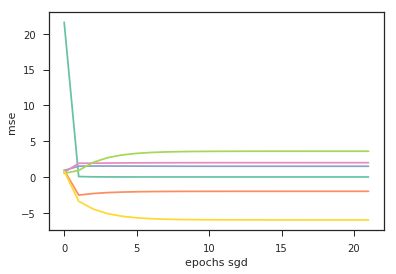

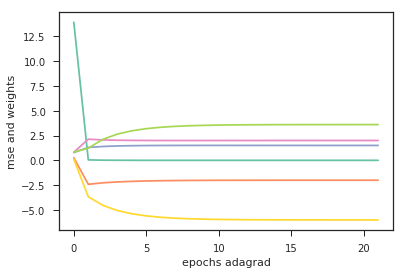

weights at adagrad epoch 10:  [-2.01203368  1.50210452  1.99611103  3.54997972 -5.95081766]


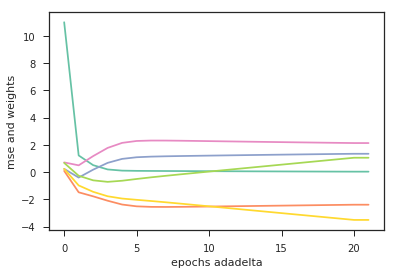

weights at adadelta epoch 10:  [-2.52411465  1.21361406  2.27749647  0.04187826 -2.5073929 ]


In [147]:
#sgd = SGD(0.1,0,20)
#sgd.fit(X,y,"SGD")
plt.plot(sgd_fit.plot_epoch, sgd_fit.plot_errors)
weight_transpose = np.array(sgd_fit.plot_weights).transpose()
plt.plot(sgd_fit.plot_epoch, weight_transpose[0])
plt.plot(sgd_fit.plot_epoch, weight_transpose[1])
plt.plot(sgd_fit.plot_epoch, weight_transpose[2])
plt.plot(sgd_fit.plot_epoch, weight_transpose[3])
plt.plot(sgd_fit.plot_epoch, weight_transpose[4])
plt.xlabel("epochs sgd")
plt.ylabel("mse")
print("weights at sgd epoch 10: ", sgd_fit.plot_weights[10])
plt.show()
plt.plot(adagrad_fit.plot_epoch, adagrad_fit.plot_errors)
weight_transpose = np.array(adagrad_fit.plot_weights).transpose()
plt.plot(adagrad_fit.plot_epoch, weight_transpose[0])
plt.plot(adagrad_fit.plot_epoch, weight_transpose[1])
plt.plot(adagrad_fit.plot_epoch, weight_transpose[2])
plt.plot(adagrad_fit.plot_epoch, weight_transpose[3])
plt.plot(adagrad_fit.plot_epoch, weight_transpose[4])
plt.xlabel("epochs adagrad")
plt.ylabel("mse and weights")
plt.show()
print("weights at adagrad epoch 10: ", adagrad_fit.plot_weights[10])
plt.plot(adadelta_fit.plot_epoch, adadelta_fit.plot_errors)
weight_transpose = np.array(adadelta_fit.plot_weights).transpose()
plt.plot(adadelta_fit.plot_epoch, weight_transpose[0])
plt.plot(adadelta_fit.plot_epoch, weight_transpose[1])
plt.plot(adadelta_fit.plot_epoch, weight_transpose[2])
plt.plot(adadelta_fit.plot_epoch, weight_transpose[3])
plt.plot(adadelta_fit.plot_epoch, weight_transpose[4])
plt.xlabel("epochs adadelta")
plt.ylabel("mse and weights")
plt.show()
print("weights at adadelta epoch 10: ", adadelta_fit.plot_weights[10])

### 3 
#### 1 Amond SGD and Adagrad, which one allows for larger initial setting of the learning_rate? Why?

Adagrad does, because the "efffective" learning rate will slowly decay for Adagrad which helps to prevent divergence. 

#### 2 Mention one benefit and one drawback of Adadelta over Adagrad

One benefit of Adadelta over Adagrad is that it is not so dependent on the initial learning rate and initial samples. Adagrad will have change very aggressively in the beginning and then slow down, so if the first few samples send Adagrad to a bad solution, Adagrad will struggle to correct that bad solution. A drawback of Adadelta would be that Adadelta requires a bit of warm up time for the learning rate because its using the average of previous values, so initial samples will have less effect on the solution than later values. This is ok if we have a lot of data, but with less data this could become a real issue. 

# Question 2. (6+4=10 pts) Tensor Playground
Visit http://playground.tensorflow.org for this problem

A. From the far right, select "Regression" as the problem type, and select the 2nd of the two data sets ( the right one ).  

   i) What sort of test / training loss do you get if you run it for 200 epochs with the following learning rates: .3, .01 and .003 ?  What if you run it for 1000 epochs with these learning rates?  Leave all other values at their defaults ( test/training ratio 50%, Noise 0, Batch Size 10, using Tanh activation function, and No Regularization )
   
   ii) Keeping learning rate at .3, Activation at Tanh, with all others at their defaults, and running for 200 epochs.  
     What sort of test/train loss can you achieve using only 1 neuron in the first hidden layer.  What about for 2,3 or 8 neurons?  Provide screen shots of output layer and comment on how the different output fits look and compare with one another.

   iii)Now keeping learning rate at .03 with all others at their defaults, and running for 200 epochs.  
       Compare how the activation functions affect the ouput ( ReLU, Sigmoid, Tanh, Linear ). Provide screen shots of output results and comment.


B. Neural Nets can fit anything.  Now reset to the initial defaults, and select "Classification" as the problem type, and from the Data section, select the bottom right "Spriral" data set.  With the idea of trying to minimize training/testing error, provide solutions to the problem for the following 2 scenarios.  i) Using just the first 2 inputs ( as per default ) and ii) Using all 7 of the inputs.  You may use as many layers as you want, whatever activation, however man neurons.  Provide screen shots which show your full network, output and parameters. Briefly justify your decisions, and comment on difficulties/tradeoffs, what helps/what doesn't,etc. 

## ANSWER

### i
200 Epochs
0.3 - test loss: 0.020, training loss: 0.016

0.01 - test loss: .04, training loss: 0.03

0.003 - test loss: 0.046, training loss: 0.036

1000 Epochs
0.3 - test loss: 0.012, training loss: 0.009

0.01 - test loss: 0.019, training loss: 0.016

0.003 - test loss: 0.024, training loss: 0.019

### ii
1 Neuron in 1st Hidden Layer

test: 0.041, training: 0.038

We can see that with just one neuron in the hidden layer the model lacks power in order to accurately predict this dataset. This is because the limited number of weights can not represent this function. 
<img src="2_1.png">

2 Neurons in Hidden Layer

test: 0.029, training: 0.027

As we add more features the models complexity increases and so does the power to represent more complicated functions. As we increase the number of weights our power increases and we can represent more complicated functions.
<img src="2_2.png">

3 neurons in Hidden Layer

test: 0.022, training: 0.020

This was a very big improvement, now we start to see the model correctly identifying the 3 very blue and 3 very orange areas. 

<img src="2_3.png">

8 neurons in Hidden Layer

test: 0.016, training: 0.015

The model was already doing pretty well, which is why we do not see as large an improvement from 3 neurons to 8 neurons as from 2 to 3. We can see from this lowered benefit that we are near or already passed the threshold of the most powerful network which we need. It is very possible with increased complexity we may see no benefit at all because of overfitting.
<img src="2_4.png">

### iii

tanh, test loss: 0.022, training loss 0.020

tanh does the best of any function for this problem. We see it does the best at generalizing the data as well in that the boundaries look more natural. 
<img src="2_5.png">

RelU, test loss: 0.027, training loss 0.027

RelU is very powerful because of its ability to not saturate. However, we also have the problem of neurons dying because of them falling into the less than 0 region of the RelU. 

<img src="2_6.png">

Sigmoid, test loss: 0.041, training loss 0.044

Sigmoid really struggles with this data set. I believed simgoid was supposed to be quite good, however it looks like it really struggles. This is possibly because of it not being zero centered which restricts later nodes in the model because no negative values can come out of the non linearity. 

<img src="2_7.png">

Linear, test loss: 0.040, training loss 0.044

It is clear to see why linear would struggle with this problem given the data we are trying to model is clearly non linear.

<img src="2_8.png">

### b part i
For this problem I knew I was going to need a deep and complex network in order to get a good solution. A lot of weights would be needed in order to turn just 2 features into this output. I also felt that depth would be good in order to generalize the shape of the spiral. Because I figured I would need a large and deep network, I though RelU would be better to help with the weight decay problem when using the tanh function. However, it did take me quite a few tries when running this network to get a really good answer because the space in which to get lost in is so much larger with this complicated of a network. 
<img src="2_9.png">

### ii
For this problem I chose to go with a smaller and less deep network. Because of the inclusion of the other features, there are now non linear functions which can really help when trying to predict something complicated like a spiral. The two sin functions are very beneficial because of their circular nature too. Because of these additional features, I felt less neurons would be needed. Because less neurons were needed and the depth of the network was not too large, I believed a tanh function would do quite well. I did have to run this one a few times to get a really good answer, but not nearly as many times as the network in part i.
<img src="2_10.png">

# Question 3: Multi-layer Perceptron Regressor (15 points)

In this question, you will explore the application of Multi-layer Perceptron (MLP) regression using sklearn package in Python. We will use the OpenCL gemm kernel performance prediction dataset for this problem https://archive.ics.uci.edu/ml/datasets/SGEMM+GPU+kernel+performance.

Following code will pre-process the data and split the data into training and test set using [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with **random state 42** and **test_size = 0.33**.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,KFold)
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
%matplotlib inline

data = pd.read_csv('sgemm_product.csv') 
data['target'] = 0.25*(data['Run1 (ms)'] + data['Run2 (ms)']+ data['Run3 (ms)'] + data['Run4 (ms)'])
y = data['target']
X = data.drop(['target','Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(161872, 14) (161872,) (79728, 14) (79728,)


One more thing to use in this problem is [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Instead of fitting a model on original data, use StandardScaler to make each feature centered ([Example](http://scikit-learn.org/stable/auto_examples/applications/plot_prediction_latency.html#sphx-glr-auto-examples-applications-plot-prediction-latency-py)). Whenever you have training and test data, fit a scaler on training data and use this scaler on test data. Here, scale only features (independent variables), not target variable y.

Use [sklearn.neural_nework.MLPRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor) to do a 5-fold cross validation using sklearn's [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold). The cross validation must be performed on the **training data**. 

1) Use following parameter settings for MLPRegressor:

    activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42,
    batch_size=5000, learning_rate_init = 0.005
    
Now, consider the following settings for the number of hidden units:
    
        (2,), (10,), (20,), (30,), (40,)
    
   Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for each model (5pts)
      
2) Now, using the same number of hidden units used in part 1), train MLPRegressor models on whole training data and report RMSE score for both Train and Test set (Again, use StandardScaler). Which model works the best? Briefly analyze the result in terms of the number of hidden units. (3pts)

3) MLPRegressor has a built-in attribute *loss\_curve\_* which returns the loss at each epoch (misleadingly referred to as "iteration" in scikit documentation, though they use epoch in the actual code!). For example, if your model is named as *my_model* you can call it as *my\_model.loss\_curve\_* ([example](http://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py)). Plot three curves for model (a), (b), and (c) in one figure, where *X-axis* is epoch  number and *Y-axis* is squared root of *loss\_curve\_* value. (2pts)

4) Activation Layer: Use the tanh and relu activations for the following fixed parameters to train your model:
    
    solver = 'sgd', random_state=42,
    batch_size=5000, hidden_layer_sizes = (2,)

   Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for each model. (2pts)
   
5) Optimization technique: The sklearn API performs a momentum update when using SGD. To understand the difference in performance of vanilla SGD and SGD with momentum, set momentum to 0 with SGD. Here, we compare the performance of vanilla sgd against adam solvers. Since both of these use different optimization subroutines, the learning rate must also be varied. In this question, vary the learning rate through these values [1, 0.1, 0.01, 0.001]. Keep the following fixed parameters to train your model:

    activation = 'tanh', random_state=42,
    batch_size=5000, hidden_layer_sizes = (2,), momentum = 0
    
   Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for the best learning rate for each model. (3pts)

## Solution

### 1)

In [3]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

kf = KFold(n_splits=5, random_state=42)
models = []

for num_hidden_units in [(2,), (10,), (20,), (30,), (40,)]:
    rmse = 0
    
    for train_index, test_index in kf.split(X_train, y_train):
        X_kf_train, X_kf_test = X_train[train_index], X_train[test_index]
        y_kf_train, y_kf_test = y_train.iloc[train_index], y_train.iloc[test_index]

        MLP = MLPRegressor(hidden_layer_sizes=num_hidden_units, activation='tanh',
                           solver='sgd', learning_rate='constant', random_state=42,
                           batch_size=5000, learning_rate_init=0.005)
        MLP_fit = MLP.fit(X_kf_train, y_kf_train)
        models.append(MLP_fit)
        
        rmse += np.sqrt(mean_squared_error(MLP_fit.predict(X_kf_test), y_kf_test))
    
    rmse /= 5
    
    print(str(num_hidden_units), "has RMSE of", rmse)

(2,) has RMSE of 231.74348462925587
(10,) has RMSE of 91.57336273414737
(20,) has RMSE of 63.394796289483
(30,) has RMSE of 52.084173514212715
(40,) has RMSE of 44.7335967365785


### 2)

In [4]:
MLP = MLPRegressor(hidden_layer_sizes=(40,), activation='tanh',
                   solver='sgd', learning_rate='constant', random_state=42,
                   batch_size=5000, learning_rate_init=0.005)
MLP_fit = MLP.fit(X_train, y_train)
rmse = np.sqrt(mean_squared_error(MLP_fit.predict(X_test), y_test))
print("40 hidden units yields test RMSE of", rmse)

40 hidden units yields test RMSE of 40.759332262496365


### 3)

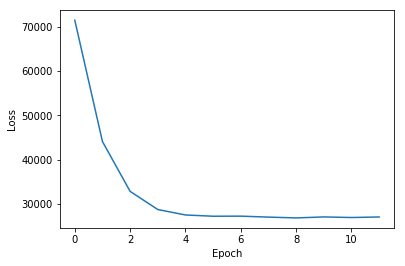

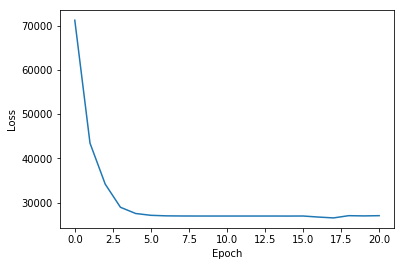

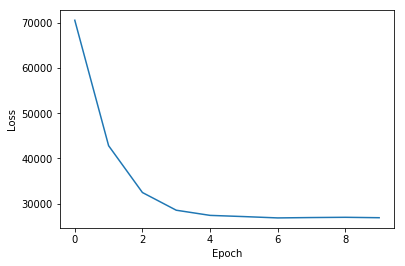

In [5]:
losses = [np.array(models[0].loss_curve_), np.array(models[1].loss_curve_), np.array(models[2].loss_curve_)]

for loss in losses:
    plt.plot(loss)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show()

### 4)

In [6]:
kf = KFold(n_splits=5, random_state=42)

for activation_func in ['tanh', 'relu']:
    rmse = 0
    
    for train_index, test_index in kf.split(X_train, y_train):
        X_kf_train, X_kf_test = X_train[train_index], X_train[test_index]
        y_kf_train, y_kf_test = y_train.iloc[train_index], y_train.iloc[test_index]

        MLP = MLPRegressor(hidden_layer_sizes=(2,), activation=activation_func,
                           solver='sgd', random_state=42, batch_size=5000)
        MLP_fit = MLP.fit(X_kf_train, y_kf_train)
        
        rmse += np.sqrt(mean_squared_error(MLP_fit.predict(X_kf_test), y_kf_test))
    
    rmse /= 5
    
    print(str(activation_func), "has RMSE of", rmse)

tanh has RMSE of 232.14074826411985
relu has RMSE of 110.8250860146275


### 5)

In [8]:
kf = KFold(n_splits=5, random_state=42)
learning_rates = [1, .1, .01, .001]

for solver in ['sgd', 'adam']:
    learning_rmses = []
    for learning_rate in learning_rates:
        rmse = 0

        for train_index, test_index in kf.split(X_train, y_train):
            X_kf_train, X_kf_test = X_train[train_index], X_train[test_index]
            y_kf_train, y_kf_test = y_train.iloc[train_index], y_train.iloc[test_index]

            MLP = MLPRegressor(activation = 'tanh', random_state=42, solver=solver,
                               batch_size=5000, hidden_layer_sizes = (2,), momentum = 0)
            MLP_fit = MLP.fit(X_kf_train, y_kf_train)

            rmse += np.sqrt(mean_squared_error(MLP_fit.predict(X_kf_test), y_kf_test))

        learning_rmses.append(rmse / 5)

    best_rate = learning_rates[np.argmax(learning_rmses)]
    print(solver, "has best learning rate", best_rate, "with RMSE of", rmse)

sgd has best learning rate 1 with RMSE of 1196.7801086690245


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


adam has best learning rate 1 with RMSE of 2097.8839839087423


# Question 4: Multi-level Model in Python (19 points)
In this problem, you will explore multi-level model using a python package [PyMC3](https://pymc-devs.github.io/pymc3/index.html#). The dataset "brew_by_year.csv" will be used in this question.  This dataset contains fields:

- `state`
- `state_id`
- `brew`
- `year`

Where `brew` is the number of breweries in the state that year, and `state_id` is a unique ID for that state.

MLM is a Bayesian modeling technique which assumes a prior distribution over the parameters. This allows us to define (multilevel) relationships between the parameters. In general, this yields a posterior that is, in general, intractable. However, we can still perform inference using Monte-Carlo Markov Chain methods by generating samples from this distribution! PyMC3 helps us do this. Also, remember that this is a Bayesian method; we are estimating a distribution for each parameter rather than just a single value.


(a)  (2 pts) Plot the relationship between number of breweries and year, and draw a linearly regressed line ignoring the ID variable. Use `LinearRegression` from `sklearn`.

(b)  (2 pts) Plot the relationship between number of breweries and year, but this time, fit a different linear regression for each state. Use `LinearRegression` from `sklearn`.

(c)  (2 + 4 + 6 pts) Divide the dataset into training and test sets.  The training set contains the first 6 years of the measurements, and the test set contains the rest of the measurements. 
Build three different linear models:
- Global model:  a linear model using `brew` as the dependent variable and `year` as the independent variable. Pool all data and estimate one common regression model to assess the influence of the passage of time across the total number of breweries. Use `LinearRegression` from `sklearn`. This is similar to part a).
- Local model:  a different linear model for each state i.e., 51 different linear regressions. We are interested in whether different states actually follow separate regression models. Use `LinearRegression` from `sklearn`. This is similar to part b).
- Multilevel model:  Use the PyMC3 package to fit a multilevel model specified as follows:

\begin{align*}
\text{brew}_{it} &= \beta_{0i} + \beta_{1i} \text{year}_{it} + \epsilon_{it}\\
\beta_{0i} &= \beta_{00}  + \eta_{0i} \\
\beta_{1i} &= \beta_{10} + \eta_{1i} \\
\end{align*}

Predict the number of breweries for the remaining years, and calculate the mean squared errors from the three models. You may find this link helpful: [Partial pooling: Hierarchical Regression aka, the best of both worlds](http://pymc-devs.github.io/pymc3/notebooks/GLM-hierarchical.html#Partial-pooling:-Hierarchical-Regression-aka,-the-best-of-both-worlds). Note the usage of `pm.sample` which generates samples from the posterior and `pm.traceplot` which provides a nice set of plots showing the estimated posterior distribution. We assume a gaussian prior over the coefficients of our linear model, so the most likely estimate is the mean of the samples from the distribution. To calculate the MSE of the MLM, take the average over the MSEs at the state level.

(d)  (2 pts) Briefly state what do $\beta_{00}$ and $\beta_{10}$ mean in this multilevel model.

(e) (1 pt) Visually assess from the trace plot whether the MLM specified in the problem is a reasonable choice.

In [67]:
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np

data = pd.read_csv('brew_by_year.csv', index_col=0)
data['brew'] = (data['brew'] - np.mean(data['brew'])) / np.std(data['brew'])

## Answer
### a)

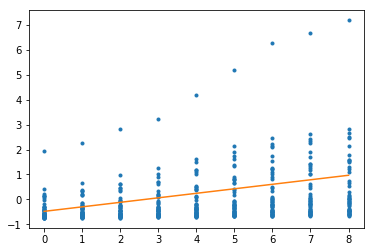

In [68]:
lin_fit = linear_model.LinearRegression().fit(np.array([data['year']]).T, np.array([data['brew']]).T)
plt.plot(np.array(data['year']), np.array(data['brew']), '.')

p0 = lin_fit.intercept_
p1 = lin_fit.coef_ * 8

plt.plot([0, 8], [p0, p1], '-')
plt.show()

### b)

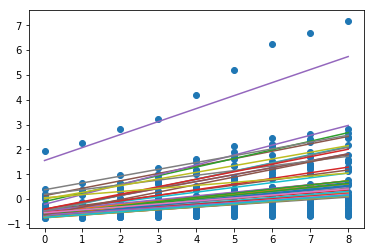

In [69]:
plt.scatter(np.array(data['year']), np.array(data['brew']))
for state_id in range(max(data['state_id'])):
    state_data = data.loc[data['state_id'] == state_id]
    lin_fit = linear_model.LinearRegression().fit(
        np.array([state_data['year']]).T, np.array([state_data['brew']]).T)
    
    p0 = lin_fit.intercept_
    p1 = lin_fit.coef_ * 8
    plt.plot([0, 8], [p0, p1], '-')

plt.show()

### c)

In [70]:
train_data = data.loc[data['year'] < 6]
test_data = data.loc[data['year'] >= 6]

In [71]:
# Global
lin_fit = linear_model.LinearRegression().fit(
    np.array([train_data['year']]).T, np.array([train_data['brew']]).T)
lin_predict = lin_fit.predict(np.array([test_data['year']]).T)
global_mse = mean_squared_error(np.array([test_data['brew']]).T, lin_predict)

In [72]:
# Local
local_mse = 0
for state_id in range(max(data['state_id'])):
    train_state_data = train_data.loc[train_data['state_id'] == state_id]
    test_state_data = test_data.loc[test_data['state_id'] == state_id]
    
    lin_fit = linear_model.LinearRegression().fit(
        np.array([train_state_data['year']]).T, np.array([train_state_data['brew']]).T)
    
    lin_predict = lin_fit.predict(np.array([test_state_data['year']]).T)
    local_mse += mean_squared_error(np.array([test_state_data['brew']]).T, lin_predict)

In [79]:
# MLM
mlm_mse = 0
with pm.Model():
    # Specify the hyper-parameter of Multilevel model:
    beta_00 = pm.Normal('mu_beta0', mu=0., sd=10)
    eta_0i = pm.HalfCauchy('eta_0', 5)
    beta_10 = pm.Normal('mu_beta1', mu=0., sd=10)
    eta_1i = pm.HalfCauchy('eta1', 5)

    # Intercept and Slope
    beta_0i = pm.Normal('beta0', mu=beta_00, sd=eta_0i, shape=len(train_data.state_id.unique()))
    beta_1i = pm.Normal('beta1', mu=beta_10, sd=eta_1i, shape=len(train_data.state_id.unique()))    
    # Model error
    eps = pm.HalfCauchy('eps', 5)

    results = []
    for per_state in train_data.groupby(train_data.state_id):
        result = beta_0i + beta_1i * per_state.year + eps
        results.append(result)

AttributeError: 'tuple' object has no attribute 'year'

In [66]:
print("Global regression MSE:", global_mse)
print("Local regression MSE:", local_mse)

Global regression MSE: 1.6792813652008016
Local regression MSE: 1.3194951203614638


# Question 5: Decision Tree using Python (5 pts)
In this problem, you will model the data using decision trees to perform a classification task on the energy dataset provided. The dataset has been preprocessed. Using the class tree.DecisionTreeClassifier (http://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree), build two different trees with a maximum depth of two using the split criteria (i) Gini and (ii) Entropy. Use entire data to build trees. Plot the two trees. If your classifier object is called clf, use the following commands to save the generated tree as a '.dot' file that can be used to visualize the tree using Webgraphviz: http://www.webgraphviz.com/

Hint: see  http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

Copy paste the contents of your '.dot' file into the text window on the website to visualize the trees. At which node(s) do they differ?

In [82]:
import pandas as pd
import numpy as np
import sklearn.tree
from sklearn.externals.six import StringIO

data = pd.read_csv('energydata_complete.csv') 

y = data['Appliances']
X = data.drop(['date','Appliances', 'rv1', 'rv2'], axis = 1)


from dateutil import parser
timeData = np.array(data['date'])

days = []
hours = []
for line in range(len(timeData)):
    day = parser.parse(timeData[line]).weekday()
    hour = parser.parse(timeData[line]).hour
    days.append(day)
    hours.append(hour)
    
X = pd.concat([X, pd.get_dummies(days), pd.get_dummies(hours)], axis = 1)

for split_type in ['gini', 'entropy']:
    tree = sklearn.tree.DecisionTreeClassifier(
        criterion=split_type, max_depth=2, random_state=42)
    tree.fit(X, y)
    
    with open("decision_tree_%s.dot" % split_type, 'w') as f:
        f = sklearn.tree.export_graphviz(tree, out_file=f)

### Entropy
<img src="5_entropy.png" />

### Gini
<img src="5_gini.png" />

# Question 6. (2+5+3=10 pts) Bayes Decision Theory
a. Explain what you understand by class-conditional likelihood, class priors, and posterior probability of a class given an input, and the relationship between them. Please define all symbols and equations used explicitly.
( 2 points )

b. Suppose you want to learn a binary classifier to predict whether or not a customer will buy a TV. The class label is 0 if the customer does not buy a TV and 1 if they do. For each customer, you are given two features, $x_1$ is the per hour salary and $x_2$ is the age. Assume that the class conditional distribution $p([x_1 , x_2]|C)$ is Gaussian. The mean salary and age of the people who do buy a TV is 15 and 40 respectively and that of those who don’t is 8.5 and 25. The first class of customers, $\sigma_1$ = 1, $\sigma_2 = 2$ and $\rho = 0$. For the second class of customers, $\sigma_1$ = 3, $\sigma_2 = 2$ and $\rho = 0$.(Refer HW1 on how to construct a covariance matrix with this information). Further, your sales data suggests that only 1 in 3 people actually bought a TV in the last few years. Mathematically derive the (optimal) Bayes decision boundary for this problem. (5 points)

c. Now sample 1000 customers from each class (C = 0, 1) under the assumed distribution and the estimated parameters and plot their features. Additionally, plot the decision boundary you obtained in the part (b) on the same plot. (3 points)

## ANSWER

### a
Class conditional likelihood function - $p([x_1,x_2]|C_i)$ 
This is likelihood of $x_1, x_2$ given the class. 

Class priors - $P(C_i)$
This is the likelihood a given datapoint is apart of class $Ci$

Posterior probability - $p(C_i|[x_1,x_2]) = \frac{P(C_i)p([x_1,x_2]|C_i)}{p([x_1, x_2])}$
This is the likelihood that for a given $x_1, x_2$ the datapoint is apart of class $C_i$. The optimal decision for each $x_1, x_2$ is to choose the $p(C_i|[x_1,x_2])$ which is greatest for that $x_1 and x_2$. 

Bayes decision boundary (boundaries) = $P(C_0| [x_1,x_2]) = P(C_1| [x_1,x_2])$
We need to choose whichever posterior probability is higher, so whenever these quantities are equal, this will be our decision boundary. When solving for this boundary we do not even need to compare the denominators in the posterior probability because they will cancel out. Therefor this equation is really just $P(C_0)p([x_1,x_2]|C_0) = P(C_1)p([x_1,x_2]|C_1)$

### b



\begin{equation} \mu_0 = \left[ \begin{array}{cc} 15 \\ 40  \end{array} \right] \end{equation}

\begin{equation} \Sigma_0 = \left[ \begin{array}{cc} 1 & 0 \\ 0 & 4 \end{array} \right] \end{equation}

\begin{equation} \Sigma_0^{-1} = \left[ \begin{array}{cc} 1 & 0 \\ 0 & 0.25 \end{array} \right] \end{equation}

$\mid\Sigma_0\mid = 4$

\begin{equation} \mu_1 = \left[ \begin{array}{cc} 8.5 \\ 25  \end{array} \right] \end{equation}

\begin{equation} \Sigma_1 = \left[ \begin{array}{cc} 9 & 0 \\ 0 & 4 \end{array} \right] \end{equation}

\begin{equation} \Sigma_1^{-1} = \left[ \begin{array}{cc} 0.111 & 0 \\ 0 & 0.25 \end{array} \right] \end{equation}

$\mid\Sigma_1\mid = 36$

$P(C_0) = 2/3$

$P(C_1) = 1/3$

$P(C_0)p([x_1,x_2]|C_0) = P(C_1)p([x_1,x_2]|C_1)$

$2/3N(\mu_0,\Sigma_0) = 1/3N(\mu_1,\Sigma_1)$

$\ln(2/3) + \ln(N(\mu_0,\Sigma_0)) = \ln(1/3) + \ln(N(\mu_1,\Sigma_1))$

$\ln(2/3)+-1/2(\vec{x}-\mu_0)^T\Sigma^{-1}_0(\vec{x}-\mu_0)\ln(2\pi\mid\Sigma_0\mid^{1/2})=\ln(1/3) + -1/2(\vec{x} - \mu_1)^T\Sigma^{-1}_1(\vec{x}-\mu_1)\ln(2\pi\mid\Sigma_1\mid^{1/2})$

A lot of reduction that I did by hand, included at end

$-1.265x_1^2 + 37.95x_1 - 0.316x_2^2 + 25.3x_2 - 791.03 = -0.2x_1^2 + 3.43x_1 - 0.454x_2^2 + 22.69x_2 - 299.25$

$-1.065x_1^2 + 34.52x_1 + 0.138x_2^2 + 2.61x_2 - 491.78 = 0$

The above equation I put into Wolfram Alpha to reduce to equation used for plotting in code

### c

In [ ]:
# Part B
import numpy as np
import seaborn as sns
sns.set(style='ticks', palette='Set2')
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import math
from scipy.stats import multivariate_normal
%matplotlib inline

def covariance(cov_x_2, cov_y_2, corr):
    return np.array([[cov_x_2, corr * np.sqrt(cov_y_2)], [corr * np.sqrt(cov_x_2), cov_y_2]])

def boundary_1(x):
    return 0.00724638*(3.87298*math.sqrt(9798*x*x - 317584*x + 4.63791e6) - 1305)
def boundary_2(x):
    return 0.00724638*(-3.87298*math.sqrt(9798*x*x - 317584*x + 4.63791e6) - 1305)

mean_c0_x = np.array([15,40])
mean_c1_x = np.array([8.5,25])
cov_c0_x = covariance(1., 4., 0.)
cov_c1_x = covariance(9., 4., 0.)
c0_x, c0_y = gauss_1 = np.random.multivariate_normal(mean_c0_x, cov_c0_x, size=1000).T
c1_x, c1_y = gauss_2 = np.random.multivariate_normal(mean_c1_x, cov_c1_x, size=1000).T
#sns.kdeplot(c0_x, c0_y)
plt.scatter(c0_x,c0_y, c='red', s=5.0)
plt.scatter(c1_x, c1_y, c='blue', s=5.0)
X = np.linspace(0,20,2000)
y_1 = []
y_2 = []
for x in X:
    y_1.append(boundary_1(x))
    y_2.append(boundary_2(x))
plt.plot(X, y_1)
plt.plot(X, y_2)
plt.xlabel("salary")
plt.ylabel("age")
plt.show()
print("red is people who dont buy a tv and blue is people who do")
#sns.kdeplot(c1_x, c1_y)

Additional math to derive decision boundary

<img src="6_math.png">